Imports

In [ ]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
from torchvision import datasets, transforms

Constants

In [ ]:
input_size = 784
depth = 6
width = 128

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
args={}
kwargs={}
args['batch_size']=32
args['epochs']=100  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=1e-4 #Learning rate is how fast it will decend. 
args['eps']=1e-7

args['cuda']=False
args['log_interval']=10


Load the dataset

In [ ]:
#load the data, and normalize it

mnist_transforms=[
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
     ]

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)


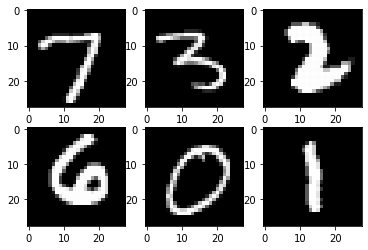

In [ ]:
import matplotlib.pyplot as plt 
examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show() 

Train and test function for the models

In [ ]:
def train(epoch):
    lossFn = nn.CrossEntropyLoss()
    loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        
        data = data.reshape(-1, 28*28).to(device)
        target = target.to(device)

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        
        # loss = F.nll_loss(output, target)
        loss = lossFn(output, target)

        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 

    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data))

def test():
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()

        data = data.reshape(-1, 28*28).to(device)
        target = target.to(device)

        output = model(data)

        # test_loss += F.nll_loss(output, target, size_average=False).data
        test_loss += lossFn(output, target).data.item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

ReLu network

In [ ]:
class Relu(nn.Module):
  def __init__(self, depth, width):
    super(Relu, self).__init__()
    self.depth = depth
    self.width = width
    setattr(self,'R1', nn.Linear(input_size, width))
    for i in range(depth - 2):
        setattr(self,'R{}'.format(i+2), nn.Linear(width, width))

    self.output = nn.Linear(width, 10) # activation = "softmax", name = "R"+str(depth))(R1)

  def forward(self, x, **kwargs):
    R1 = F.relu(getattr(self,'R1')(x))
    for i in range(self.depth-2):
      R1 = F.relu(getattr(self,'R{}'.format(i+2))(R1))

    return self.output(R1)

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
history_relu = {'acc':[], 'val_acc':[], 'loss': [], 'val_loss': []}

In [ ]:
model = Relu(6, 128)
print(model)
print()
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Relu(
  (R1): Linear(in_features=784, out_features=128, bias=True)
  (R2): Linear(in_features=128, out_features=128, bias=True)
  (R3): Linear(in_features=128, out_features=128, bias=True)
  (R4): Linear(in_features=128, out_features=128, bias=True)
  (R5): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
)

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.337397

Test set: Average loss: 78.0091, Accuracy: 9250/10000 (92%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.246019

Test set: Average loss: 56.8312, Accuracy: 9452/10000 (95%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.102343

Test set: Average loss: 42.7277, Accuracy: 9567/10000 (96%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.254051

Test set: Average loss: 39.7655, Accuracy: 9599/10000 (96%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.019654

Test set: Average loss: 37.9948, Accuracy: 9650/10000 (96%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.045088

Test 

Decoupled Learning network with soft ReLU

In [ ]:
eps, beta = 0.1, 4

In [ ]:
class SoftGate(nn.Module):
    def __init__(self, **kwargs):
        super(SoftGate, self).__init__()

    def build(self, input_shape):
        super(SoftGate, self).build(input_shape)  # Be sure to call this at the end

    def forward(self, x):
        activation = (1 + eps)*F.sigmoid(beta*x)
        return activation

    def compute_output_shape(self, input_shape):
        return input_shape

class DecoupledLearning(nn.Module):
  def __init__(self, depth, width):

    super(DecoupledLearning, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'R1', nn.Linear(input_size, width))

    setattr(self,'G1', nn.Linear(input_size, width))

    for i in range(depth - 2):
      setattr(self,'R{}'.format(i+2), nn.Linear(width, width))

      setattr(self,'G{}'.format(i+2), nn.Linear(width, width))

    self.outputs = nn.Linear(width, 10)
      
  def forward(self, x):
    R1 = getattr(self,'R1')(x)
    R1A = F.relu(R1)
    A1 = SoftGate()(R1)

    G1 = getattr(self,'G1')(x)
    G1A = torch.mul(G1, A1)

    for i in range(self.depth-2):
      R1 = getattr(self,'R{}'.format(i+2))(R1A)
      R1A = F.relu(R1)      
      A1 = SoftGate()(R1)

      G1 = getattr(self,'G{}'.format(i+2))(G1A)
      G1A = torch.mul(G1, A1)

    return self.outputs(G1A)

In [ ]:
model = DecoupledLearning(6, 128)
print(model)
print()
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

DecoupledLearning(
  (R1): Linear(in_features=784, out_features=128, bias=True)
  (G1): Linear(in_features=784, out_features=128, bias=True)
  (R2): Linear(in_features=128, out_features=128, bias=True)
  (G2): Linear(in_features=128, out_features=128, bias=True)
  (R3): Linear(in_features=128, out_features=128, bias=True)
  (G3): Linear(in_features=128, out_features=128, bias=True)
  (R4): Linear(in_features=128, out_features=128, bias=True)
  (G4): Linear(in_features=128, out_features=128, bias=True)
  (R5): Linear(in_features=128, out_features=128, bias=True)
  (G5): Linear(in_features=128, out_features=128, bias=True)
  (outputs): Linear(in_features=128, out_features=10, bias=True)
)



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.492965

Test set: Average loss: 48.6603, Accuracy: 9543/10000 (95%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.067670

Test set: Average loss: 34.8555, Accuracy: 9654/10000 (97%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.016897

Test set: Average loss: 30.4128, Accuracy: 9695/10000 (97%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.019364

Test set: Average loss: 28.0258, Accuracy: 9732/10000 (97%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.012244

Test set: Average loss: 27.8741, Accuracy: 9731/10000 (97%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.003773

Test set: Average loss: 28.9548, Accuracy: 9725/10000 (97%)

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.091763

Test set: Average loss: 28.2029, Accuracy: 9745/10000 (97%)

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.003674

Test set: Average loss: 26.8941, Accuracy: 9769/10000 (98%)

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.000701

Test set: Average loss: 28.0652, Accuracy: 9

Decoupled learning with hard ReLU activation

In [ ]:
class SignGate(nn.Module):
  def __init__(self, **kwargs):
      super(SignGate, self).__init__(**kwargs)

  def build(self, input_shape):
      super(SignGate, self).build(input_shape)  # Be sure to call this at the end

  def forward(self, x):
      output = torch.sign(F.relu(x))
      return output

  def compute_output_shape(self, input_shape):
      return input_shape
      
  
class Galu(nn.Module):

  def __init__(self, depth, width):
    super(Galu, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'R1', nn.Linear(input_size, width))

    setattr(self,'G1', nn.Linear(input_size, width))

    for i in range(depth - 2):
      setattr(self,'R{}'.format(i+2), nn.Linear(width, width))

      setattr(self,'G{}'.format(i+2), nn.Linear(width, width))

    self.outputs = nn.Linear(width, 10)

  def freezeLayerR(self):
    for i in range(1,6):
      getattr(self, 'R{}'.format(i)).requires_grad = False
      
  def forward(self, x):
    R1 = F.relu(getattr(self,'R1')(x))
    A1 = SignGate()(R1)

    G1 = getattr(self,'G1')(x)
    G1A = torch.mul(G1, A1)

    for i in range(self.depth-2):
      R1 = F.relu(getattr(self,'R{}'.format(i+2))(R1))      
      A1 = SignGate()(R1)

      G1 = getattr(self,'G{}'.format(i+2))(G1A)
      G1A = torch.mul(G1, A1)

    return self.outputs(G1A)


In [ ]:
model = Galu(6, 128)
print(model)
print()
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Galu(
  (R1): Linear(in_features=784, out_features=128, bias=True)
  (G1): Linear(in_features=784, out_features=128, bias=True)
  (R2): Linear(in_features=128, out_features=128, bias=True)
  (G2): Linear(in_features=128, out_features=128, bias=True)
  (R3): Linear(in_features=128, out_features=128, bias=True)
  (G3): Linear(in_features=128, out_features=128, bias=True)
  (R4): Linear(in_features=128, out_features=128, bias=True)
  (G4): Linear(in_features=128, out_features=128, bias=True)
  (R5): Linear(in_features=128, out_features=128, bias=True)
  (G5): Linear(in_features=128, out_features=128, bias=True)
  (outputs): Linear(in_features=128, out_features=10, bias=True)
)

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.336282

Test set: Average loss: 109.5237, Accuracy: 8953/10000 (90%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.109688

Test set: Average loss: 74.3465, Accuracy: 9266/10000 (93%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.263122

Test set: Average loss: 61.4839, Accu

FRNPF(II)

In [ ]:
model = Galu(6, 128)
model

Galu(
  (R1): Linear(in_features=784, out_features=128, bias=True)
  (G1): Linear(in_features=784, out_features=128, bias=True)
  (R2): Linear(in_features=128, out_features=128, bias=True)
  (G2): Linear(in_features=128, out_features=128, bias=True)
  (R3): Linear(in_features=128, out_features=128, bias=True)
  (G3): Linear(in_features=128, out_features=128, bias=True)
  (R4): Linear(in_features=128, out_features=128, bias=True)
  (G4): Linear(in_features=128, out_features=128, bias=True)
  (R5): Linear(in_features=128, out_features=128, bias=True)
  (G5): Linear(in_features=128, out_features=128, bias=True)
  (outputs): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
for name, param in model.named_parameters():
    if name[0]=='R':
        param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

G1.weight
G1.bias
G2.weight
G2.bias
G3.weight
G3.bias
G4.weight
G4.bias
G5.weight
G5.bias
outputs.weight
outputs.bias


In [ ]:
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.429225

Test set: Average loss: 108.8231, Accuracy: 8940/10000 (89%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.071385

Test set: Average loss: 74.0679, Accuracy: 9274/10000 (93%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.252288

Test set: Average loss: 61.1804, Accuracy: 9401/10000 (94%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.308776

Test set: Average loss: 53.8918, Accuracy: 9460/10000 (95%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.164819

Test set: Average loss: 49.0676, Accuracy: 9488/10000 (95%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.014278

Test set: Average loss: 50.4661, Accuracy: 9501/10000 (95%)

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.092907

Test set: Average loss: 46.1685, Accuracy: 9546/10000 (95%)

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.063042

Test set: Average loss: 46.6205, Accuracy: 9554/10000 (96%)

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.021147

Test set: Average loss: 49.1171, Accuracy: 

FRNPF(DI)

In [ ]:
model = Galu(6, 128)
model

Galu(
  (R1): Linear(in_features=784, out_features=128, bias=True)
  (G1): Linear(in_features=784, out_features=128, bias=True)
  (R2): Linear(in_features=128, out_features=128, bias=True)
  (G2): Linear(in_features=128, out_features=128, bias=True)
  (R3): Linear(in_features=128, out_features=128, bias=True)
  (G3): Linear(in_features=128, out_features=128, bias=True)
  (R4): Linear(in_features=128, out_features=128, bias=True)
  (G4): Linear(in_features=128, out_features=128, bias=True)
  (R5): Linear(in_features=128, out_features=128, bias=True)
  (G5): Linear(in_features=128, out_features=128, bias=True)
  (outputs): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[-0.0175,  0.0339, -0.0281,  ...,  0.0258, -0.0037,  0.0338],
        [ 0.0236,  0.0342,  0.0038,  ..., -0.0260, -0.0349,  0.0076],
        [-0.0275, -0.0221, -0.0112,  ...,  0.0019,  0.0136,  0.0007],
        ...,
        [ 0.0115,  0.0184,  0.0234,  ...,  0.0205,  0.0050,  0.0284],
        [-0.0114, -0.0229,  0.0006,  ...,  0.0051, -0.0103,  0.0282],
        [-0.0113,  0.0345, -0.0118,  ...,  0.0204,  0.0284, -0.0018]],
       requires_grad=True)
Parameter containing:
tensor([-0.0225, -0.0062,  0.0227,  0.0352,  0.0107, -0.0216, -0.0232, -0.0265,
        -0.0234, -0.0093,  0.0210, -0.0132, -0.0127, -0.0029, -0.0132,  0.0042,
        -0.0021,  0.0261, -0.0014, -0.0122,  0.0184,  0.0115,  0.0082,  0.0310,
        -0.0116,  0.0003,  0.0146, -0.0232, -0.0065, -0.0240,  0.0178, -0.0343,
        -0.0024,  0.0196, -0.0353,  0.0123, -0.0129, -0.0095,  0.0153, -0.0166,
         0.0172, -0.0236, -0.0061, -0.0190,  0.0245,  0.0040, -0.0090, -0.0273,
        -0.0350

In [ ]:
model.state_dict().get("G1.weight").data

tensor([[-0.0268, -0.0019, -0.0206,  ..., -0.0338, -0.0258, -0.0098],
        [ 0.0146,  0.0321,  0.0136,  ...,  0.0295,  0.0227, -0.0296],
        [ 0.0325, -0.0236,  0.0151,  ...,  0.0265, -0.0236, -0.0078],
        ...,
        [-0.0221,  0.0159, -0.0223,  ..., -0.0282, -0.0025, -0.0354],
        [ 0.0207, -0.0067, -0.0311,  ..., -0.0025,  0.0296,  0.0335],
        [ 0.0189,  0.0232,  0.0314,  ...,  0.0111,  0.0220,  0.0248]])

In [ ]:
for name, param in model.named_parameters():
    if name[0]=='R':
      paramName = "G"+name[1:]
      param.data = model.state_dict().get(paramName).data
      param.requires_grad = False
    print(name, param)


R1.weight Parameter containing:
tensor([[-0.0268, -0.0019, -0.0206,  ..., -0.0338, -0.0258, -0.0098],
        [ 0.0146,  0.0321,  0.0136,  ...,  0.0295,  0.0227, -0.0296],
        [ 0.0325, -0.0236,  0.0151,  ...,  0.0265, -0.0236, -0.0078],
        ...,
        [-0.0221,  0.0159, -0.0223,  ..., -0.0282, -0.0025, -0.0354],
        [ 0.0207, -0.0067, -0.0311,  ..., -0.0025,  0.0296,  0.0335],
        [ 0.0189,  0.0232,  0.0314,  ...,  0.0111,  0.0220,  0.0248]])
R1.bias Parameter containing:
tensor([ 0.0109, -0.0037, -0.0197,  0.0098,  0.0161,  0.0081,  0.0201, -0.0259,
         0.0262,  0.0200, -0.0032, -0.0346,  0.0186,  0.0045, -0.0066, -0.0170,
        -0.0325, -0.0039, -0.0323,  0.0112,  0.0258, -0.0253,  0.0236, -0.0068,
         0.0116, -0.0208, -0.0221, -0.0124, -0.0246,  0.0110, -0.0018, -0.0332,
         0.0353,  0.0035, -0.0262, -0.0352, -0.0287,  0.0284, -0.0221, -0.0053,
         0.0057, -0.0105,  0.0224,  0.0350, -0.0206, -0.0168,  0.0286, -0.0139,
        -0.0102, -0.0147

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

G1.weight
G1.bias
G2.weight
G2.bias
G3.weight
G3.bias
G4.weight
G4.bias
G5.weight
G5.bias
outputs.weight
outputs.bias


In [ ]:
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.059813

Test set: Average loss: 86.2581, Accuracy: 9186/10000 (92%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.320187

Test set: Average loss: 60.0275, Accuracy: 9408/10000 (94%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.033653

Test set: Average loss: 47.8090, Accuracy: 9542/10000 (95%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.046542

Test set: Average loss: 47.8092, Accuracy: 9550/10000 (96%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.009930

Test set: Average loss: 36.7361, Accuracy: 9636/10000 (96%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.011075

Test set: Average loss: 31.5736, Accuracy: 9695/10000 (97%)

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.063425

Test set: Average loss: 33.4118, Accuracy: 9666/10000 (97%)

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.101278

Test set: Average loss: 29.8511, Accuracy: 9717/10000 (97%)

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.015318

Test set: Average loss: 27.8059, Accuracy: 9

FLNPF

In [ ]:
model = Relu(6, 128)
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.234286

Test set: Average loss: 80.1784, Accuracy: 9221/10000 (92%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.513418

Test set: Average loss: 55.7940, Accuracy: 9456/10000 (95%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.068985

Test set: Average loss: 47.8331, Accuracy: 9529/10000 (95%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.030178

Test set: Average loss: 42.0575, Accuracy: 9590/10000 (96%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.212829

Test set: Average loss: 37.2943, Accuracy: 9646/10000 (96%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.204465

Test set: Average loss: 35.7969, Accuracy: 9655/10000 (97%)

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.159987

Test set: Average loss: 29.9535, Accuracy: 9701/10000 (97%)

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.011684

Test set: Average loss: 29.3101, Accuracy: 9700/10000 (97%)

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.091108

Test set: Average loss: 33.3716, Accuracy: 9

In [ ]:
relu_model = model
for p in model.parameters():
  print(p)

Parameter containing:
tensor([[-0.0066,  0.0350, -0.0066,  ..., -0.0092, -0.0324, -0.0259],
        [-0.0005,  0.0318, -0.0215,  ...,  0.0027,  0.0216, -0.0264],
        [ 0.0020, -0.0008, -0.0146,  ..., -0.0097,  0.0312,  0.0331],
        ...,
        [-0.0247, -0.0067, -0.0246,  ...,  0.0317, -0.0288, -0.0078],
        [ 0.0301,  0.0334,  0.0133,  ..., -0.0307,  0.0081,  0.0216],
        [ 0.0255,  0.0199, -0.0239,  ..., -0.0074, -0.0154,  0.0319]],
       requires_grad=True)
Parameter containing:
tensor([ 6.8783e-03, -7.1925e-03, -4.0269e-02, -2.0070e-02, -1.1682e-02,
        -2.3824e-02,  4.0018e-02, -4.2927e-02, -9.5298e-03,  2.8930e-03,
        -2.2812e-02,  1.6409e-02,  1.6204e-02, -1.5028e-02, -1.0336e-02,
         2.0358e-02, -4.9963e-03,  3.3359e-02,  1.7695e-02,  1.3409e-02,
         2.2361e-02,  3.3353e-02, -2.0574e-02, -2.2784e-02,  6.8703e-03,
         3.0454e-02,  1.7202e-02,  3.9294e-02, -5.9534e-03,  6.4410e-03,
        -2.2518e-03, -1.2908e-02, -1.6700e-02,  2.3940e-0

In [ ]:
model = Galu(6, 128)

In [ ]:
for p in relu_model.parameters():
  print(p)

Parameter containing:
tensor([[-0.0066,  0.0350, -0.0066,  ..., -0.0092, -0.0324, -0.0259],
        [-0.0005,  0.0318, -0.0215,  ...,  0.0027,  0.0216, -0.0264],
        [ 0.0020, -0.0008, -0.0146,  ..., -0.0097,  0.0312,  0.0331],
        ...,
        [-0.0247, -0.0067, -0.0246,  ...,  0.0317, -0.0288, -0.0078],
        [ 0.0301,  0.0334,  0.0133,  ..., -0.0307,  0.0081,  0.0216],
        [ 0.0255,  0.0199, -0.0239,  ..., -0.0074, -0.0154,  0.0319]],
       requires_grad=True)
Parameter containing:
tensor([ 6.8783e-03, -7.1925e-03, -4.0269e-02, -2.0070e-02, -1.1682e-02,
        -2.3824e-02,  4.0018e-02, -4.2927e-02, -9.5298e-03,  2.8930e-03,
        -2.2812e-02,  1.6409e-02,  1.6204e-02, -1.5028e-02, -1.0336e-02,
         2.0358e-02, -4.9963e-03,  3.3359e-02,  1.7695e-02,  1.3409e-02,
         2.2361e-02,  3.3353e-02, -2.0574e-02, -2.2784e-02,  6.8703e-03,
         3.0454e-02,  1.7202e-02,  3.9294e-02, -5.9534e-03,  6.4410e-03,
        -2.2518e-03, -1.2908e-02, -1.6700e-02,  2.3940e-0

In [ ]:
trained_params = [x.data for x in relu_model.parameters()]

i=0
for (name, params) in model.named_parameters():
  if name[0]=='R':
    params.data = trained_params[i]
    params.requires_grad = False
    i+=1
  print(name, params)

R1.weight Parameter containing:
tensor([[-0.0066,  0.0350, -0.0066,  ..., -0.0092, -0.0324, -0.0259],
        [-0.0005,  0.0318, -0.0215,  ...,  0.0027,  0.0216, -0.0264],
        [ 0.0020, -0.0008, -0.0146,  ..., -0.0097,  0.0312,  0.0331],
        ...,
        [-0.0247, -0.0067, -0.0246,  ...,  0.0317, -0.0288, -0.0078],
        [ 0.0301,  0.0334,  0.0133,  ..., -0.0307,  0.0081,  0.0216],
        [ 0.0255,  0.0199, -0.0239,  ..., -0.0074, -0.0154,  0.0319]])
R1.bias Parameter containing:
tensor([ 6.8783e-03, -7.1925e-03, -4.0269e-02, -2.0070e-02, -1.1682e-02,
        -2.3824e-02,  4.0018e-02, -4.2927e-02, -9.5298e-03,  2.8930e-03,
        -2.2812e-02,  1.6409e-02,  1.6204e-02, -1.5028e-02, -1.0336e-02,
         2.0358e-02, -4.9963e-03,  3.3359e-02,  1.7695e-02,  1.3409e-02,
         2.2361e-02,  3.3353e-02, -2.0574e-02, -2.2784e-02,  6.8703e-03,
         3.0454e-02,  1.7202e-02,  3.9294e-02, -5.9534e-03,  6.4410e-03,
        -2.2518e-03, -1.2908e-02, -1.6700e-02,  2.3940e-02, -2.925

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
      print(name)

G1.weight
G1.bias
G2.weight
G2.bias
G3.weight
G3.bias
G4.weight
G4.bias
G5.weight
G5.bias
outputs.weight
outputs.bias


In [ ]:
lossFn = nn.CrossEntropyLoss()

if args['cuda']:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.000033

Test set: Average loss: 49.7263, Accuracy: 9774/10000 (98%)

Train Epoch: 2 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 63.0740, Accuracy: 9778/10000 (98%)

Train Epoch: 3 [59968/60000 (100%)]	Loss: 0.000001

Test set: Average loss: 71.9596, Accuracy: 9787/10000 (98%)

Train Epoch: 4 [59968/60000 (100%)]	Loss: 0.000002

Test set: Average loss: 82.7685, Accuracy: 9792/10000 (98%)

Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 96.0699, Accuracy: 9780/10000 (98%)

Train Epoch: 6 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 111.0783, Accuracy: 9785/10000 (98%)

Train Epoch: 7 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 118.0895, Accuracy: 9785/10000 (98%)

Train Epoch: 8 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 126.6504, Accuracy: 9785/10000 (98%)

Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.000000

Test set: Average loss: 154.4929, Accurac